In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power
import copy

In [2]:
#GNEP
#linearized coupled inverted pendulum

In [3]:
# linearized continuous system
# theta_1, theta_1',x_1,x_1', theta_2,theta_2', x_2,x_2'
g=9.81 #gravity
k_sp=1 #spring constante
d=3   #length of relaxed spring
l=1    #length

A=np.array([[0,1,0,0,       0,0,0,0],
            [g/l,0,k_sp/l,0,    0,0,-k_sp/l,0],
            [0,0,0,1,       0,0,0,0],
            [0,0,-k_sp,0,      0,0,k_sp,0],
            [0,0,0,0,       0,1,0,0],
            [0,0,-k_sp/l,0,       g/l,0,k_sp/l,0],
            [0,0,0,0,       0,0,0,1],
            [0,0,k_sp,0,       0,0,-k_sp,0]])
B=np.array([[0,0],
           [-1/l,0],
           [0,0],
           [1,0],
           [0,0],
           [0,-1/l],
           [0,0],
           [0,1]])


nx=8 #dimension of state
nu=2 #dimension of control (in total)
Nu=2 #amount of players
sampling_rate=0.1 

In [4]:
#stationary state
x_ast=np.array([0.0,0.0,0,0.0, 0.0,0.0,d,0.0])
N=5 #horizon length

In [5]:
#discretize system via RK4
steps = 1
dt = sampling_rate/steps

C= -A@x_ast

A_k1 = A
B_k1 = B
C_k1= C
            
A_k2 = A + A@A_k1*(dt/2)
B_k2 = A@B_k1*(dt/2) + B
C_k2=A@C_k1*(dt/2)+C
            
A_k3 = A + A @ A_k2*(dt/2)
B_k3 = A@B_k2*(dt/2) + B
C_k3=A@C_k2*(dt/2)+C
            
A_k4 = A + A @ A_k3 * dt
B_k4 = A@B_k3*dt + B
C_k4=A@C_k3*(dt)+C
            
A_rk4 = (A_k1 + A_k2*2 + A_k3*2 + A_k4)*(dt/6)
B_rk4 = (B_k1 + B_k2*2 + B_k3*2 + B_k4)*(dt/6)
C_rk4 = (C_k1 + C_k2*2 + C_k3*2 + C_k4)*(dt/6)


A_cont=A
B_cont=B
C_cont=C
A = np.eye(nx)   
B= np.zeros((nx,nu))
C=np.zeros(C.shape)
for i in range(steps):
    C = C+ A@C_rk4
    B = B+ A@B_rk4
    A = A+ A@A_rk4   

In [6]:
#put 4 time steps into one to gurantee controllability in one step
#reagrrange such that B=(B_nu, B_{-nu})
B1=np.concatenate([matrix_power(A,k)@B[:,0].reshape(-1,1) for k in reversed(range(4))], axis=1)
B2=np.concatenate([matrix_power(A,k)@B[:,1].reshape(-1,1) for k in reversed(range(4))], axis=1)
B=np.concatenate((B1,B2), axis=1)
np.linalg.matrix_rank(B)
C=C+A@C+A@A@C+A@A@A@C
A=matrix_power(A,4)  
nu=4*nu

In [ ]:
#discretization of nonlinear dynamics
g_a=9.81
def f(x,u):
    th1=x[1]
    th2=x[5]
    x1=x[3]
    x2=x[7]
    
    dth1=(g_a/l)*np.sin(x[0])-(1/l)*np.cos(x[0])*(u[0]+k_sp*(x[6])-x[2]-d)
    dth2=(g_a/l)*np.sin(x[4])-(1/l)*np.cos(x[4])*(u[1]+k_sp*(x[2])-x[6]+d)
    dx1=u[0]+k_sp*(x[6]-x[2]-d)
    dx2=u[1]+k_sp*(x[2]-x[6]+d)
    return np.array([th1,dth1,x1,dx1, th2,dth2, x2, dx2 ])

def f_RK4(x,u):
    k1=dt*f(x,u)
    k2=dt*f(x+(1/2)*k1,u)
    k3=dt*f(x+(1/2)*k2,u)
    k4=dt*f(x+k3,u)
    return x+(1/6)*(k1+2*k2+2*k3+k4)

def f_real(x,u):
    rearange=[0,4,  1,5, 2,6,  3,7 ]
    u=u[rearange]
    for i in range(4):
        x=f_RK4(x,u[i*2:i*2+2])
    return x

In [7]:
#parameters
alpha=0 #modification 
beta=10 #regularization of Nikaido-Isoda function
gamma=1 #penalty factor for u
b=100   #bounds

In [8]:
from scipy.optimize import Bounds
bounds = Bounds((N)*nu*[-b], (N)*nu*[b])

In [9]:
def endcond(u,x_iv):
    u=u.reshape((N,nu))
    x=x_iv
    for k in range(N):
        x=A@x+B@u[k] +C
    return x-x_ast

In [10]:
nx_p=nx//Nu
nu_p=nu//Nu
def ell(x,u,i):
    res=0.5*np.dot(x[i*nx_p:i*nx_p+nx_p]-x_ast[i*nx_p:i*nx_p+nx_p],x[i*nx_p:i*nx_p+nx_p]-x_ast[i*nx_p:i*nx_p+nx_p])
    res+=gamma*0.5*np.dot(u[i*nu_p:i*nu_p+nu_p],u[i*nu_p:i*nu_p+nu_p])
    return res

In [11]:
def inner_objective(u,x_iv,v):
    u=u.reshape((N,nu))
    v=v.reshape((N,nu))
   #input u in form (N,nu)
    su=0
    for i in range(Nu):
        x=x_iv
        contrl=copy.deepcopy(u)
        contrl[:,i*nu_p:nu_p+i*nu_p]=v[:,i*nu_p:nu_p+i*nu_p] 
        for k in range(N):
            su+= ell(x,contrl[k],i)
            x=A@x+B@contrl[k]+C     
    diff=u-v
    su+=beta*0.5*np.dot(diff.flatten(),diff.flatten())              
    return su

In [12]:
K=[matrix_power(A,k)@B for k in range(N)]
def inner_objective_jac(u,x_iv,v):
    u=u.reshape((N,nu))
    v=v.reshape((N,nu))
    jac=np.zeros((N,nu))
    for i in range(Nu):
        x=x_iv
        control=copy.deepcopy(u)
        control[:,i*nu_p:nu_p+i*nu_p]=v[:,i*nu_p:nu_p+i*nu_p]
        for k in range(N):
            diff=x[i*nx_p:i*nx_p+nx_p]-x_ast[i*nx_p:i*nx_p+nx_p]
            for n in range(0,k):
                tmp=diff@K[k-n-1][i*nx_p:i*nx_p+nx_p,i*nu_p:nu_p+i*nu_p]
                jac[n,i*nu_p:nu_p+i*nu_p]+=tmp.flatten()
            if k <N:
                x=A@x+B@control[k]+C     
        jac[:,i*nu_p:nu_p+i*nu_p]+=gamma*v[:,i*nu_p:nu_p+i*nu_p]
    jac+=beta*(v-u)    
    return jac.reshape(-1)

In [13]:
def g(x_iv,u):
    obj= lambda v: inner_objective(u,x_iv,v)
    jac= lambda v: inner_objective_jac(u,x_iv,v)
    v_0=np.zeros(u.shape).flatten()
    
    solution=minimize(obj,v_0, method="L-BFGS-B", jac=jac,bounds=bounds)
    if not solution.success:
        print("inner",solution.message)
    return solution

In [14]:
def objective(x_iv,u):
    u=u.reshape((N,nu)) 
    sec=0
    sec=(1-alpha)*g(x_iv,u).fun
    
    first=0
    x=x_iv
    for k in range(N):
        for i in range(Nu):
            first+=ell(x,u[k],i)       
        x=A@x+B@u[k]+C 
    return first-sec

In [15]:
K=[matrix_power(A,k)@B for k in range(N)]
def objective_jac(x_iv,u):  #only with respect to u
    u=u.reshape((N,nu))
    jac=np.zeros((N,nu))

    #part dependent on u only
    contrl=copy.deepcopy(u)
    x=copy.deepcopy(x_iv)
    for k in range(N):
        diff=(x-x_ast).transpose()
        for n in range(0,k):
            jac[n,:]+=diff@K[k-n-1]
        if k <N:
            x=A@x+B@contrl[k]+C 

    jac+=gamma*u
    v=g(x_iv,u).x
    v=v.reshape((N,nu))
    for i in range(Nu):
        x=x_iv
        contrl=copy.deepcopy(u)
        contrl[:,i*nu_p:nu_p+i*nu_p]=v[:,i*nu_p:nu_p+i*nu_p]
        j=1-i
        for n in range(N):
            diff=(x[i*nx_p:i*nx_p+nx_p]-x_ast[i*nx_p:i*nx_p+nx_p]).transpose()
            for k in range(0,n):
                jac[k,j*nu_p:nu_p+j*nu_p]+=-(1-alpha)*diff@K[n-k-1][i*nx_p:i*nx_p+nx_p,j*nu_p:nu_p+j*nu_p]
            if n<N:
                x=A@x+B@contrl[n]+C
    jac+=beta*(v-u)            
    return jac.reshape(-1)

In [16]:
def addnoise(x,a):
    return x+np.random.uniform(low=-a,high=a, size=x.size)
def addnoise_fac(x,b):
    y=x
    for i in range(len(x)):
        y[i]=x[i]+np.random.uniform(low=-b*np.abs(x[i]),high=b*np.abs(x[i]))
    return x

In [19]:
maxIter=100 #max. iterations
x_ivv=np.asarray([np.pi,0,0,0,0,0,d,0]) #IV
noise=0.00
op={"maxiter":1e3} #optimization parameters

In [20]:
x_iv=x_ivv
u_0=np.zeros(N*nu)
u_star=[]  #control
x_star=[]  #state
V=[]       #optimal value function
V_0=[]     #Lyapunov function
#we also solve the problem while imposing end-constraints for comparison
V_diff=[]  #difference Lyapunov function and same function evaluated at solution of problem where endconstraints where enforced

x_Last=[]  #state at end of lookahead horizon
x_Last_end=[] #state at end of lookahead horizon if endconstraints are enforced
u_diff=[]     #difference controls (with/without end constraints)
x_star.append(x_iv)
print("Lyapunov,", "optimal value,", 'optimal-value with EC,', "EC")
for i in range(maxIter):
    if i%10==0:
        print(i)
    obj= lambda u: objective(x_iv,u)
    jac= lambda u: objective_jac(x_iv,u)
    ec= lambda u: endcond(u,x_iv)
    end_cond={'type': "eq",'fun': ec}
    solution=minimize(obj,u_0,method="SLSQP",jac=jac,bounds=bounds)
     #solve problem with end constraints for comparison
    solution_end=minimize(obj,u_0,method="SLSQP",jac=jac,constraints=end_cond,bounds=bounds)
  
    if not solution.success:
        print(i, solution.message, endcond(solution.x, x_iv))
        
    contrl=solution.x
    contrl=contrl.reshape((N,nu))
    contrl_end=solution_end.x
    contrl_end=contrl_end.reshape((N,nu))
    
    x_last=x_iv
    for k in range(N):
        x_last    =A@x_last +B@contrl[k]+C
    x_Last.append(x_last)  
    x_last_end=x_iv
    for k in range(N):
        x_last_end    =A@x_last_end +B@contrl_end[k]+C
    x_Last_end.append(x_last_end) 
 

    V.append(solution.fun)
    V_0.append(inner_objective(solution.x,x_iv,solution.x))
    print(V_0[-1], V[-1], solution_end.fun, np.sum(x_Last[-1]-x_ast))
    
   
    V_diff.append(np.abs(solution_end.fun-solution.fun))
    u_diff.append(np.linalg.norm(contrl-contrl_end))
    u_curr=solution.x.reshape((N,nu))[0]
    u_star.append(u_curr)
 
    x_iv=A@x_iv+B@u_curr+C
    x_iv=addnoise_fac(x_iv, noise)
 
    x_star.append(x_iv)
    u_0=solution.x

Lyapunov, optimal value, optimal-value with EC, EC
0
4498.1525070095395 0.0004570839564621565 1856.3077430499907 89.8527722108727
1440.7893034866495 2.777000872811186e-06 2895.394926941306 66.21026933961383
1490.0252647926131 4.989894932805328e-07 3896.85223889997 59.233703926821974
1762.2778366317734 8.890901881386526e-08 4774.2330204957325 57.216153674717155
2024.1501703734384 2.1617332322421134e-05 5790.578797888054 56.28515656186375
2237.106369167904 1.8061518858303316e-06 7010.295077915958 55.223190345898885
2392.4207109531512 3.439498323132284e-05 8268.190220755627 53.660877128741475
2502.861725132575 2.3617718397872522e-05 9058.592518881458 51.51986082771017
2577.4838733067863 2.6901512228505453e-05 8971.314724967247 48.8463953183941
2605.1690901182246 2.1590935830317903e-06 8560.91765659982 45.72970812305786
10
2565.615771429488 1.0756657502497546e-05 8227.24388685105 42.230217735567365
2453.2029096881192 4.957367764291121e-06 7977.977756873079 38.46114316935541
2286.3595691403

In [21]:
import os
dictname="CIP/zero"
os.makedirs(dictname)

In [22]:
with open(dictname+"/stats.txt", "w") as file:
    file.write("alpha="+str(alpha))
    file.write("\n")
    file.write("inital value="+str(x_ivv))
    file.write("\n")
    file.write("N="+str(N))
    file.write("\n")
    file.write("noise="+str(noise))
    file.write("\n")
    file.write("U=["+str(-b)+","+str(b)+"]")
    file.write("\n")
    file.write("gamma="+str(gamma))
    file.write("\n")
    file.write("beta="+str(beta))
    file.write("\n")
    file.write("spring="+str(k_sp))
    file.write("\n")
    file.write("rod_length="+str(l))

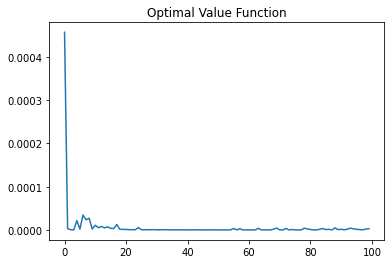

In [23]:
plt.plot(V)
plt.title('Optimal Value Function')
plt.savefig("./"+dictname+"/optimalvalue.png")

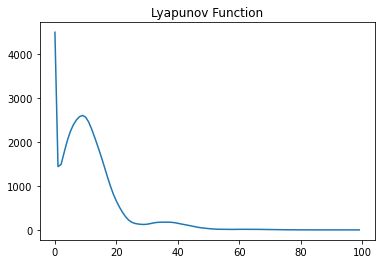

In [24]:
plt.plot(V_0)
plt.title('Lyapunov Function')
plt.savefig("./"+dictname+"/lyapunov.png")

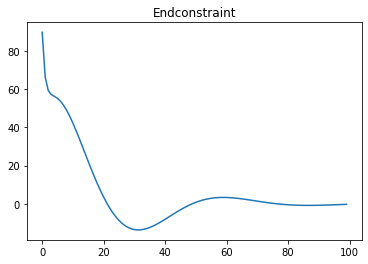

In [26]:
X_Last=[x-x_ast for x in x_Last]
X_Last=np.asarray(X_Last)
plt.plot(np.sum(X_Last, axis=1))
plt.title("Endconstraint")
plt.savefig("./"+dictname+"/endcond.png")

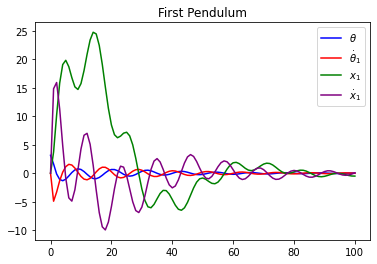

In [27]:
X_star=np.asarray(x_star)

plt.plot(X_star[:,0],"blue", label=r"$\theta$")
plt.plot(X_star[:,1],"red", label=r"$\dot{\theta}_1$")
plt.plot(X_star[:,2],"green", label=r"$x_1$")
plt.plot(X_star[:,3],"purple",label=r"$\dot{x}_1$")
plt.legend()
plt.title("First Pendulum")
plt.savefig("./"+dictname+"/pendulum1.png")

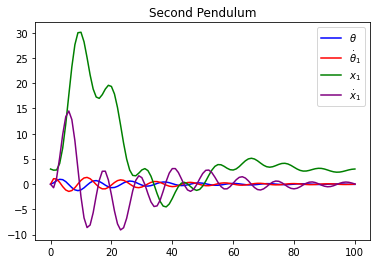

In [28]:
X_star=np.asarray(x_star)

plt.plot(X_star[:,4],"blue", label=r"$\theta$")
plt.plot(X_star[:,5],"red", label=r"$\dot{\theta}_1$")
plt.plot(X_star[:,6],"green", label=r"$x_1$")
plt.plot(X_star[:,7],"purple",label=r"$\dot{x}_1$")
plt.legend()
plt.title("Second Pendulum")
plt.savefig("./"+dictname+"/pendulum2.png")

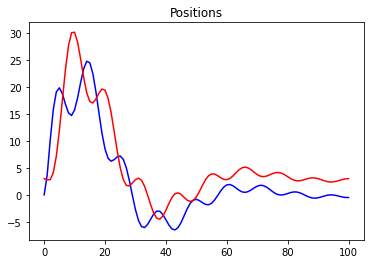

In [29]:
plt.plot(X_star[:,2],"blue")
plt.plot(X_star[:,6],"red")
plt.title('Positions')
plt.savefig("./"+dictname+"/positions.png")

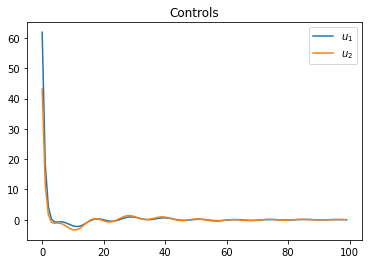

In [30]:
U_star=np.asarray(u_star)
plt.plot(U_star[:,0], label=r"$u_1$")
plt.plot(U_star[:,1],label=r"$u_2$")
plt.legend()
plt.title('Controls')
plt.savefig("./"+dictname+"/controls.png")